# Super Tuesday Single Site Data Set Analysis tool.

## Select site of interest
Enter the name the Count Site as described in the ../script_output/count_observations directory

In [34]:
site = 'B-SydneyRdParkSt'
# Note: In the file system its Suburb dash road name

In [35]:
datadir = './script_output/count_observations/'
target = datadir + site + "/*/*"

## Are you interested in the 7am - 9am period or the 'peak hour' of the survey?

In [36]:
# To report on peak hour leave this line uncommended and ensure "reporting = '7to9'" is commented out
reporting = 'peakhour'
#reporting = '7to9'

## Are you interested in the intersection or the routes leading to the intersection?
Change the "interest" value to focus on the road or shared path segment you are most interested in.

In [37]:
allmoves = ['north_turn_left','north_through','north_turn_right',\
             'east_turn_left','east_through', 'east_turn_right',\
             'south_turn_left','south_through','south_turn_right',\
             'west_turn_left','west_through','west_turn_right']


from_north =['north_turn_left','north_through','north_turn_right']
to_north = ['west_turn_left','south_through', 'east_turn_right']

path_north_of_intersection = from_north + to_north


from_east = ['east_turn_left', 'east_through', 'east_turn_right']
to_east = ['south_turn_left', 'west_through', 'north_turn_right']

path_east_of_intersection = from_east + to_east


from_south =['south_turn_left', 'south_through', 'south_turn_right']
to_south = ['east_turn_left', 'north_through', 'west_turn_right']

path_south_of_intersection = from_south + to_south


from_west = ['west_turn_left', 'west_through', 'west_turn_right']
to_west = ['north_turn_left', 'east_through', 'south_turn_right']

path_west_of_intersection = from_west + to_west

In [38]:
# Specify Directions of interest
interest = allmoves

#interest = from_north
#interest = to_north
#interest = path_north_of_intersection

#interest = from_east
#interest = to_east
#interest = path_east_of_intersection

#interest = from_south
#interest = to_south
#interest = path_south_of_intersection

#interest = from_west
#interest = to_west
#interest = path_west_of_intersection


goodcols = ['time', 'gender'] + interest

## Are you interested in all riders at a count site, or a specific gender?

In [39]:
gender = 'allriders'
#gender = 'female'
#gender = 'male'

### Collect totals for each survey year

In [40]:
# Calculate bicycle volume for each survey year with gender flag
import pandas as pd
import glob
import datetime as dt

bikevolume = pd.DataFrame(columns=('year', 'peakhour','volume'))

for f in glob.glob(target):
    countobs = pd.read_csv(f, sep=', ', header = 0, usecols = goodcols, parse_dates=[0], \
                           infer_datetime_format=True, engine = 'python')
    
    if gender == 'female':
        females = countobs.query('gender == "F"')
        females.index = females['time']

        cols = list(females)
        cols.remove('time')
        cols.remove('gender')

        riders = females[cols]     
    
    elif gender == 'male':
        males = countobs.query('gender == "M"')
        males.index = males['time']

        cols = list(males)
        cols.remove('time')
        cols.remove('gender')

        riders = males[cols] 
    
    else:
        riders = pd.DataFrame(countobs.groupby('time').sum())

    ridertotal = pd.DataFrame()
    ridertotal['total'] = riders.sum(axis=1,numeric_only=True)

    if reporting == 'peakhour':
        volume = 0
        ridertotal['hourlytotal'] = ridertotal.total.rolling(window=4,center=False).sum()
        volume = ridertotal.hourlytotal.max()
        rawpeakhour = ridertotal.hourlytotal.idxmax()
        peakhour = rawpeakhour - dt.timedelta(minutes=45)
        # hourly.max will report the forth bin in the largest group of four bins  
        # Bins are identified by their start time, so the peak hour starts 45min earlier than "rawpeakhour"
        peakhour = peakhour.strftime('%H:%M')
    else:
        # Reporting == '7to9'
        peakhour = 'Na'
        volume = ridertotal.total.sum()
        
    year = ridertotal.index[1].year
    bikevolume.loc[year] = [int(year), peakhour, int(volume)]
 
bikevolume

,year,peakhour,volume
2003,2003.0,08:00,323.0
2009,2009.0,08:00,494.0
2011,2011.0,08:00,483.0
2013,2013.0,08:00,515.0
2015,2015.0,08:00,721.0


### Graph the results
##### As a line graph

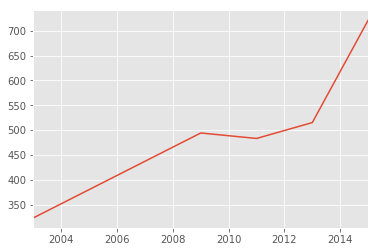

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
bikevolume.volume.plot()



##### As a scatter plot with trend line

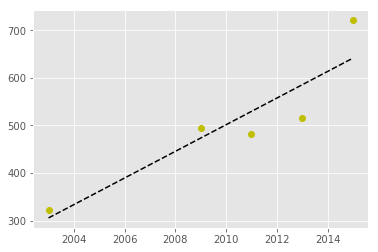

In [42]:
import matplotlib.pyplot as plt
import numpy as np
 
fit = np.polyfit(bikevolume.index,bikevolume.volume,1)
fit_fn = np.poly1d(fit)

plt.plot(bikevolume.index,bikevolume.volume,'yo', bikevolume.index, fit_fn(bikevolume.index), '--k')
plt.show()

### Use survey data to make predictions
#### Calculate the annual increase in rider numbers.
How many additional bike movements to we expect to see next year. 
The gradient of the trend line in the scatter plot  = number of additional riders per year.
Calculating increase this way helps to minimise the impact of variation in samples (e.g. weather effects, counting errors etc).

In [43]:
# Calculate Growth rates
# Annual increse in riders.
from scipy.stats import linregress

bestfit = linregress(bikevolume.index, bikevolume.volume)
annualincrease = int(round(bestfit.slope,0))
annualincrease

28

#### Use annual increase to estimate rider numbers in a future year.

In [44]:
# Predict rider numbers for a given year based on linear trend growth
predictionyr = 2017

In [45]:
from sklearn.linear_model import LinearRegression

years = bikevolume.index
years = np.array(years).reshape(len(years),1)

model = LinearRegression()
model.fit(years, bikevolume.volume)

expectedriders = model.predict(predictionyr)
expectedriders = int(round(expectedriders, 0))
expectedriders

697

#### Calculate an annualised growth rate

In [46]:
growthrate = float(annualincrease)/expectedriders*100
growthrate = round(growthrate,2)

print "Growth in rider numbers " + str(growthrate)  + "% p.a."

Growth in rider numbers 4.02% p.a.


### Thoughts on graphs where the trend line is a poor fit to the scatter plot
Using the linear trend as a measure of annualised growth trend assumes this the underlying changes in bike riding patterns is linear.  This might not be true at every site.  For example a site that has changed (e.g. because of a capital works program that makes a bike route better) might result in a change in rider numbers larger than the linear trend.  Causes for this 'larger than trend' increase could be:
 - existing riders changing their commute to work route or 
 - previous non-riders changing their commuting patterns to become bike riders.
 
Sites that have five or more observations and a scatter plot that doesn't fit a trendline are probably worth further investigation.
 

### Peak hour volume
Peak hour volume is the bike movements during the busiest hour (4 consecutive 15 minute sample bins) during the survey.  It is assumed that the busiest bicycle traffic volume hour occurs during the morning commuter peak and is over before 9am.  

Peak hour is a valuable measure because:
- It is easily understood
- It is directly comparable to peak hour volume measurements for motor vehicle trafflc and pedestrian counts (although the 'peak bicycle hour' may occur at a different time to 'peak motor vehicle hour'.
- Australian Standards for bicycle infrastructure design make recommendations for lane and path widths based on use during peak hour. 

However, as this peak hour result is derived from a small 7-9am sample, there is a reasonable chance that they busiest hour of the day lies outside the sample period.  The 'peak hour' reported from this dataset under estimate bicycle traffic volumes.

### The 7am - 9am Morning Commute sample
The 7am - 9am Morning commute sample is a data collection method unique to "Super Tuesday".  It can provide an estimate of all the bike commuters in the area if:
 - Count sites are on the most popular bike routes (cover the major exits to a suburb)
 - The sample period (7-9am) captures most of the commuting cycling 'rush hour' 
 - Commuting cyclists take direct routes that avoid crossing a count site mulitple times.

Limitations of the Super Tuesday method include:
- Under counting for locations where the 'morning rush hour' extends beyond 9am.
- Under counting for locations where a significant proportion of bike riders work outside of office hours - eg hospitals
- Over counting at locations where cyclists make 'chained trips' that invovles some back tracking - eg a parent who is counted the first time riding with their kids to school, and counted a second time whne riding from their school to their work.